In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

exp_dir = '../../experiments/DeepSTABp-lysate (long)'

coupling_types = ['codir', 'coord', 'deform']
edge_types = ['contact'] + coupling_types

plots_dir = 'plots'
os.makedirs(plots_dir, exist_ok=True)

tag = 'all-in-one'


In [2]:

setups_to_process = {
    'S1: contact (12Å)': 'v7a-simple/backbone_X-contact_12-codir_X-coord_X-deform_X', # 3.93577075
    'M2: contact (12Å) + 3 dynamic graphs (1CONT)': 'v7a-mGCN/backbone_X-contact_12-codir_1CONT-coord_1CONT-deform_1CONT', # 3.86728263
}

metric_file = 'training_history-test.csv'
metric_header = 'epoch,test_loss,test_pcc,test_rmse,test_mae,test_mse,test_r2'.split(',')

prediction_file = 'predicted_values-test_set.csv'

et_color = {
    'contact': (0., 0.6039215686274509, 0.8705882352941177),
    'codir': (0., 0.803921568627451, 0.4235294117647059),
    'coord': (0.6862745098039216, 0.34509803921568627, 0.7294117647058823),
    'deform': (1., 0.7764705882352941, 0.11764705882352941),
}

setup_hatch = {
    'S1: contact (12Å)': None,
    'S1: codir (20N)': None,
    'S1: coord (1DCONT)': None,
    'S1: deform (2DSIGMA)': None,
    'M2: backbone + contact (12Å)': '///',
    'M1: backbone + contact (12Å)': '\\\\\\',
    'M2: contact (12Å) + 3 dynamic graphs (1CONT)': '...',
}


In [3]:
# get species and ogt

src_file = f'{exp_dir}/metadata - DeepSTABp-lysate (processable) - test.csv'

info = np.loadtxt(
    src_file,
    delimiter=',',
    dtype=np.str_,
)
print(info.shape)
acc2ogt_dict = {
    e[0]: float(e[2]) for e in info
}


(2044, 4)


In [4]:
# FIND THE BEST PERFORMING FOLD ON TEST SET

all_performances = []

for setup, exp_name in setups_to_process.items():

    category, exp_name = exp_name.split('/')

    print(f'{category}/{exp_name}\n', end='')

    setup_dir = f'{exp_dir}/{category}/{exp_name}'

    # check if all folds are completed
    assert all([
        os.path.exists(f'{setup_dir}/fold{fold_idx}/{metric_file}')
        for fold_idx in range(10)
    ]), 'incomplete'
    assert not any([
        np.loadtxt(
            f'{setup_dir}/fold{fold_idx}/{metric_file}',
            delimiter=',',
        ).size == 0
        for fold_idx in range(10)
    ]), 'incomplete'

    # read test performance from each fold
    best_rmse_of_fold = []
    best_epoch_of_fold = []
    for fold_idx in range(10):
        performance = np.loadtxt(
            f'{setup_dir}/fold{fold_idx}/{metric_file}',
            delimiter=',',
        )

        best_rmse_loc = np.argmin(
            performance[:, metric_header.index('test_rmse')]
        )
        best_rmse = performance[best_rmse_loc, metric_header.index('test_rmse')]
        best_epoch = int(performance[best_rmse_loc, metric_header.index('epoch')])

        best_rmse_of_fold.append(best_rmse)
        best_epoch_of_fold.append(best_epoch)

    print(
        f'{np.min(best_rmse_of_fold):.3f} at fold {np.argmin(best_rmse_of_fold)}'
        f' (epoch {best_epoch_of_fold[np.argmin(best_rmse_of_fold)]})'
    )

    all_performances.append([
        category,
        exp_name,
        np.argmin(best_rmse_of_fold),
        best_epoch_of_fold[np.argmin(best_rmse_of_fold)],
        np.min(best_rmse_of_fold),
    ])

    print()

for performance in all_performances:
    print(performance)


v7a-simple/backbone_X-contact_12-codir_X-coord_X-deform_X
3.936 at fold 7 (epoch 9)

v7a-mGCN/backbone_X-contact_12-codir_1CONT-coord_1CONT-deform_1CONT
3.867 at fold 5 (epoch 6)

['v7a-simple', 'backbone_X-contact_12-codir_X-coord_X-deform_X', np.int64(7), 9, np.float64(3.93577075)]
['v7a-mGCN', 'backbone_X-contact_12-codir_1CONT-coord_1CONT-deform_1CONT', np.int64(5), 6, np.float64(3.86728263)]


In [5]:
# READ PREDICTED VALUES FROM BEST FOLD

accessions = []
true_values = []
predictions = []

for setup_idx, setup in enumerate(setups_to_process):

    exp_name = setups_to_process[setup]
    category, exp_name = exp_name.split('/')

    best_fold = all_performances[setup_idx][2]
    best_epoch = all_performances[setup_idx][3]
    best_rmse = all_performances[setup_idx][4]

    print(f'{category}/{exp_name}\n', end='')

    setup_dir = f'{exp_dir}/{category}/{exp_name}'

    # read predicted values from best fold, best epoch
    with open(f'{setup_dir}/fold{best_fold}/{prediction_file}', 'r') as f:
        lines = [l.replace('\n', '') for l in f.readlines()]

    for line in lines:
        if line.startswith('# epoch,'):
            accessions.append(
                [x for x in line.split(',')[1:]]
            )
        elif line.startswith('# true_labels,'):
            true_values.append(
                np.array([x for x in line.split(',')[1:]], dtype=np.float32)
            )
        elif line.startswith(f'{best_epoch},'):
            predictions.append(
                np.array([x for x in line.split(',')[1:]], dtype=np.float32)
            )

    # sanity check: rmse
    rmse = np.sqrt(np.mean((true_values[-1] - predictions[-1]) ** 2))
    if abs(rmse - best_rmse) > 1e-6:
        print(f'WARNING: RMSE mismatch! {rmse} != {best_rmse}')
    else:
        print(f'RMSE: {rmse} == {best_rmse}')

    print()

# sanity check: all true values are the same
for idx in range(len(true_values)-1):
    assert np.all(np.equal(
        true_values[idx], true_values[idx+1]
    ))
# sanity check: order of accessions are the same
for idx in range(len(accessions[0])):
    assert accessions[0][idx] == accessions[1][idx]

accessions = np.array(accessions[0])
ogts = np.array([acc2ogt_dict[acc[:-5]] for acc in accessions])


v7a-simple/backbone_X-contact_12-codir_X-coord_X-deform_X
RMSE: 3.9357709884643555 == 3.93577075

v7a-mGCN/backbone_X-contact_12-codir_1CONT-coord_1CONT-deform_1CONT
RMSE: 3.8672826290130615 == 3.86728263



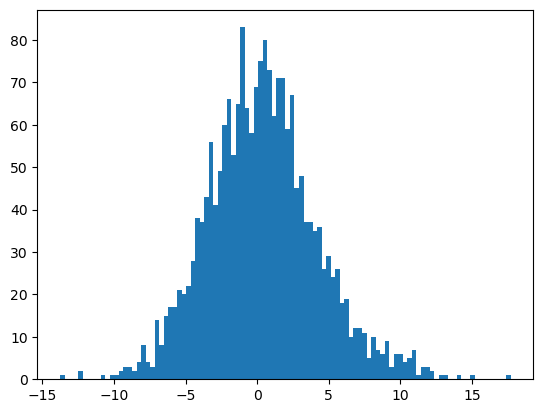

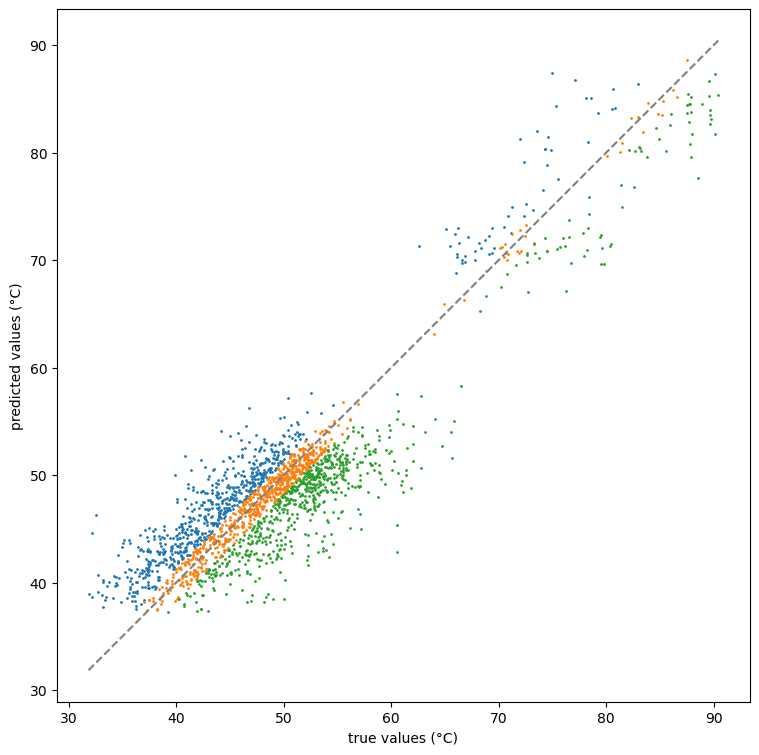

In [105]:
# TRUE VS PRED

true = true_values[-1]
pred = predictions[-1]
diff = true-pred

plt.hist(diff, bins=100)
plt.show()
plt.close()


fig, ax = plt.subplots(
    figsize=(7.48, 7.48),
    layout='constrained'
)

ax.plot(
    [min(true), max(true)],
    [min(true), max(true)],
    color='gray',
    linestyle='--',
)

loc = diff<np.percentile(diff, 100/3)
ax.scatter(
    true[loc],
    pred[loc],
    s=1,
)

loc = np.bitwise_and(
    diff>=np.percentile(diff, 100/3),
    diff<np.percentile(diff, 200/3)
)
ax.scatter(
    true[loc],
    pred[loc],
    s=1,
)

loc = diff>=np.percentile(diff, 200/3)
ax.scatter(
    true[loc],
    pred[loc],
    s=1,
)

ax.set_aspect('equal', 'box')

ax.set_xlabel('true values (°C)')
ax.set_ylabel('predicted values (°C)')

plt.show()
plt.close()


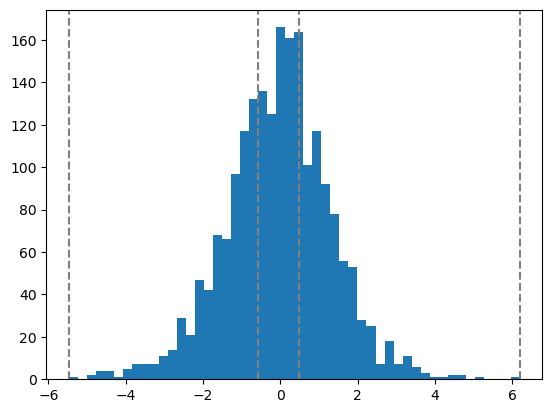

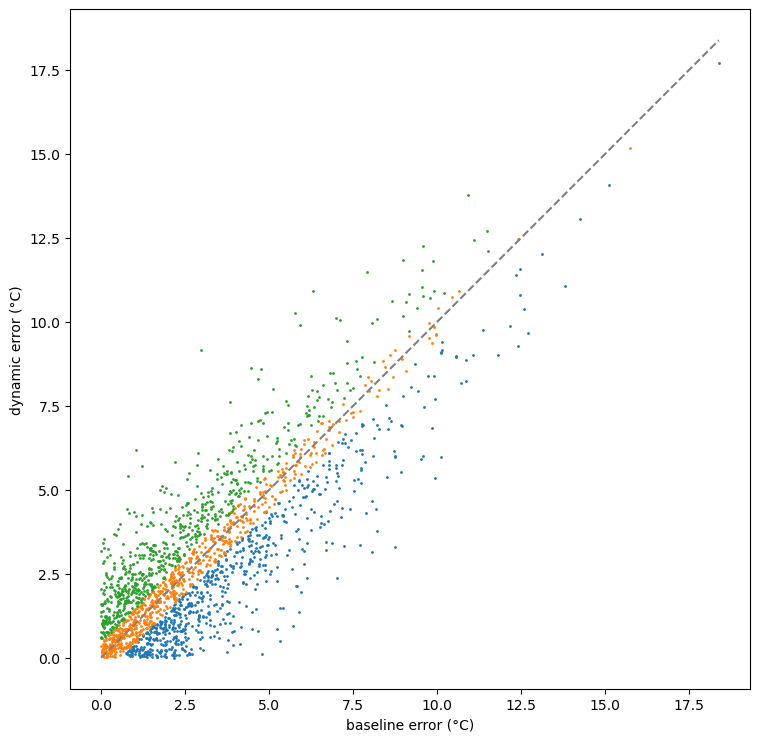

In [ ]:
# ERROR VS ERROR


base_err = np.abs(true_values[0]-predictions[0])
dyn_err = np.abs(true_values[-1]-predictions[-1])

improvements = dyn_err - base_err

plt.hist(improvements, bins=50)
for v in np.percentile(improvements, [0, 100/3, 200/3, 100]):
    plt.axvline(
        v,
        linestyle='--',
        color='gray'
    )
plt.show()
plt.close()


fig, ax = plt.subplots(
    figsize=(7.48, 7.48),
    layout='constrained'
)

ax.plot(
    [min(base_err), max(base_err)],
    [min(base_err), max(base_err)],
    color='gray',
    linestyle='--',
)

loc = improvements<np.percentile(improvements, 100/3)
ax.scatter(
    base_err[loc],
    dyn_err[loc],
    s=1,
)

loc = np.bitwise_and(
    improvements>=np.percentile(improvements, 100/3),
    improvements<np.percentile(improvements, 200/3)
)
ax.scatter(
    base_err[loc],
    dyn_err[loc],
    s=1,
)

loc = improvements>=np.percentile(improvements, 200/3)
ax.scatter(
    base_err[loc],
    dyn_err[loc],
    s=1,
)

ax.set_aspect('equal', 'box')

ax.set_xlabel('baseline error (°C)')
ax.set_ylabel('dynamic error (°C)')

plt.show()
plt.close()


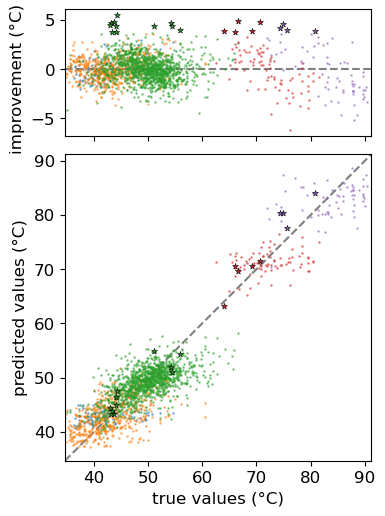

In [22]:
# IMPROVEMENT VS ACTUAL VALUE

ogt_groups = (
    3,
    (20, 30),
    (30, 40),
    60,
    70
)
labels = []


base_err = np.abs(true_values[0]-predictions[0])
dyn_err = np.abs(true_values[-1]-predictions[-1])

improvements = base_err - dyn_err
idx_sorted = np.argsort(improvements)[::-1]
ogts_sorted = ogts[idx_sorted[:20]]


fig, axes = plt.subplots(
    2, 1,
    figsize=(7.48/2, 7.48/2*1.35),
    sharex=True,
    layout='constrained',
    gridspec_kw={'height_ratios': [2, 5]}
)

### TRUE VS IMPROVEMENT
for idx, ogt_group in enumerate(ogt_groups):
    if isinstance(ogt_group, tuple):
        ogt_min, ogt_max = ogt_group
        loc = np.bitwise_and(
            ogts >= ogt_min,
            ogts < ogt_max
        )
        axes[0].scatter(
            true_values[0][loc],
            improvements[loc],
            s=0.75,
            alpha=0.5,
            c=f'C{idx}',
            # label=f'{ogt_min:.0f}-{ogt_max:.0f}°C',
        )
        ogt_str = ",".join(np.unique(ogts[loc]).astype(np.int_).astype(np.str_))
        labels.append(f'{ogt_str}°C')

        loc = np.bitwise_and(
            ogts_sorted >= ogt_min,
            ogts_sorted < ogt_max
        )
        if np.sum(loc) > 0:
            axes[0].scatter(
                true_values[0][idx_sorted[:20]][loc],
                improvements[idx_sorted[:20]][loc],
                s=20,
                marker='*',
                facecolor=f'C{idx}',
                edgecolor='black',
                linewidths=0.4,
                zorder=5,
            )
    else:
        ogt = ogt_group
        axes[0].scatter(
            true_values[0][ogts==ogt],
            improvements[ogts==ogt],
            s=0.75,
            alpha=0.5,
            c=f'C{idx}',
            # label=f'{ogt:.0f}°C',
        )
        labels.append(f'{ogt:.0f}°C')

        loc = ogts_sorted==ogt
        if np.sum(loc) > 0:
            axes[0].scatter(
                true_values[0][idx_sorted[:20]][loc],
                improvements[idx_sorted[:20]][loc],
                s=20,
                marker='*',
                facecolor=f'C{idx}',
                edgecolor='black',
                linewidths=0.4,
                zorder=5,
            )

loc = np.bitwise_and(
    dyn_err < 1,
    base_err > 4
)
axes[0].axhline(
    0,
    color='gray',
    linestyle='--',
    zorder=-1,
)

# axes[0].set_xlabel('true values (°C)', fontsize=12)
axes[0].set_ylabel('improvement (°C)  ', fontsize=12)
xlim = axes[0].get_xlim()

### TRUE VS PRED
for idx, ogt_group in enumerate(ogt_groups):
    if isinstance(ogt_group, tuple):
        ogt_min, ogt_max = ogt_group
        loc = np.bitwise_and(
            ogts >= ogt_min,
            ogts < ogt_max
        )
        axes[1].scatter(
            true_values[-1][loc],
            predictions[-1][loc],
            s=0.75,
            alpha=0.5,
            c=f'C{idx}',
            # label=f'{ogt_min:.0f}-{ogt_max:.0f}°C',
        )

        loc = np.bitwise_and(
            ogts_sorted >= ogt_min,
            ogts_sorted < ogt_max
        )
        if np.sum(loc) > 0:
            axes[1].scatter(
                true_values[-1][idx_sorted[:20]][loc],
                predictions[-1][idx_sorted[:20]][loc],
                s=20,
                marker='*',
                facecolor=f'C{idx}',
                edgecolor='black',
                linewidths=0.4,
                zorder=5,
            )
    else:
        ogt = ogt_group
        axes[1].scatter(
            true_values[-1][ogts==ogt],
            predictions[-1][ogts==ogt],
            s=0.75,
            alpha=0.5,
            c=f'C{idx}',
            # label=f'{ogt:.0f}°C',
        )

        loc = ogts_sorted==ogt
        if np.sum(loc) > 0:
            axes[1].scatter(
                true_values[-1][idx_sorted[:20]][loc],
                predictions[-1][idx_sorted[:20]][loc],
                s=20,
                marker='*',
                facecolor=f'C{idx}',
                edgecolor='black',
                linewidths=0.4,
                zorder=5,
            )

ylim = axes[1].get_ylim()
axes[1].plot(
    ylim,
    ylim,
    color='gray',
    linestyle='--',
    zorder=-1,
)

axes[1].set_aspect('equal', 'box')

axes[1].set_xlabel('true values (°C)', fontsize=12)
axes[1].set_ylabel('predicted values (°C)', fontsize=12)

axes[1].set_xlim(ylim)
axes[1].set_ylim(ylim)

# ### LEGENDS
# patches = [
#     mpatches.Patch(
#         label=labels[idx],
#         # facecolor='white',
#         # edgecolor='black',
#         color=f'C{idx}',
#         # hatch=setup_hatch[setup],
#     )
#     for idx in range(len(ogt_groups))
# ]
# axes[1].legend(
#     handles=patches,
#     loc='lower center',
#     title='optimal growth temp.',
#     title_fontsize=10,
#     fontsize=10,
#     bbox_to_anchor=(0.5, -0.55),
#     ncol=2,
# )

# tick fontsize
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.savefig(
    f'{plots_dir}/improvement_vs_actual_{tag}.png',
    dpi=300,
    bbox_inches='tight',
)
plt.show()
plt.close()


In [9]:
for a_idx, a in enumerate(accessions[idx_sorted[:20]]):
    print(a_idx, a)

0 D3YVZ9-AFv4
1 Q6L1A1-AFv4
2 P0AG51-AFv4
3 Q6KZ82-AFv4
4 P42923-AFv4
5 P0AAR3-AFv4
6 Q72KZ7-AFv4
7 P36049-AFv4
8 Q08969-AFv4
9 P02309-AFv4
10 P13663-AFv4
11 Q72GX4-AFv4
12 Q72JU4-AFv4
13 P0A9N0-AFv4
14 Q72K10-AFv4
15 Q6KYX4-AFv4
16 Q6L177-AFv4
17 Q6L2J8-AFv4
18 Q9UN37-AFv4
19 P29018-AFv4


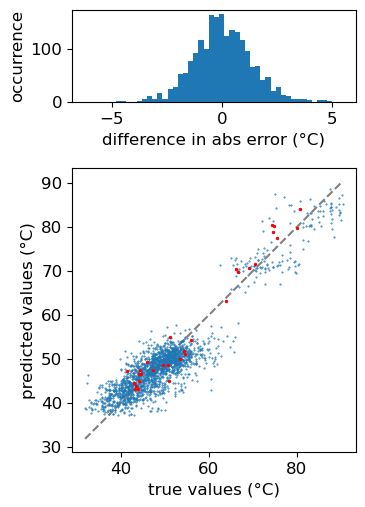

In [166]:
# IMPROVEMENT HIST + TRUE VS PRED

base_err = np.abs(true_values[0]-predictions[0])
dyn_err = np.abs(true_values[-1]-predictions[-1])

improvements = base_err - dyn_err
idx_sorted = np.argsort(improvements)[::-1]


fig, axes = plt.subplots(
    2, 1,
    figsize=(3.54, 3.54*1.4),
    layout='constrained',
    gridspec_kw={'height_ratios': [1.5, 5]}
)

### IMPROVEMENT HIST
axes[0].hist(
    improvements,
    bins=50,
    density=False,
    # s=0.2,
)
# axes[0].scatter(
#     true_values[0][idx_sorted[:30]],
#     improvements[idx_sorted[:30]],
#     s=2,
#     color='red',
#     zorder=5,
# )

axes[0].set_xlabel('difference in abs error (°C)', fontsize=12)
axes[0].set_ylabel('occurrence', fontsize=12)
# xlim = axes[0].get_xlim()

### TRUE VS PRED
axes[1].scatter(
    true_values[-1],
    predictions[-1],
    s=0.2,
)
axes[1].scatter(
    true_values[-1][idx_sorted[:30]],
    predictions[-1][idx_sorted[:30]],
    s=2,
    color='red',
    zorder=5,
)
axes[1].plot(
    [min(true_values[-1]), max(true_values[-1])],
    [min(true_values[-1]), max(true_values[-1])],
    color='gray',
    linestyle='--',
    zorder=-1,
)
# axes[1].scatter(
#     true_values[-1][loc],
#     predictions[-1][loc],
#     marker='*',
#     s=3,
#     edgecolors='black',
#     facecolors='none',
#     zorder=10
# )

axes[1].set_aspect('equal', 'box')

axes[1].set_xlabel('true values (°C)', fontsize=12)
axes[1].set_ylabel('predicted values (°C)', fontsize=12)

# axes[1].set_xlim(xlim)
# axes[1].set_ylim(ylim)

# tick fontsize
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.savefig(
    f'{plots_dir}/custom plot 2.png',
    dpi=300,
    bbox_inches='tight',
)
plt.show()
plt.close()


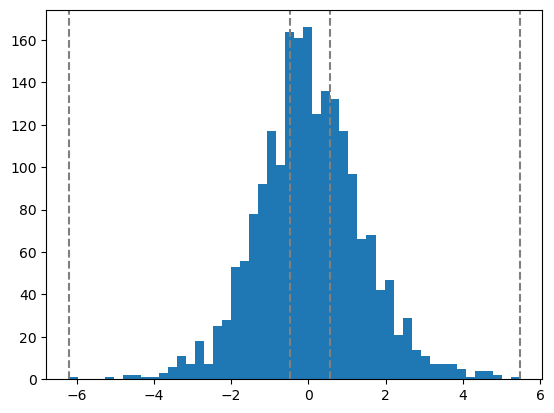

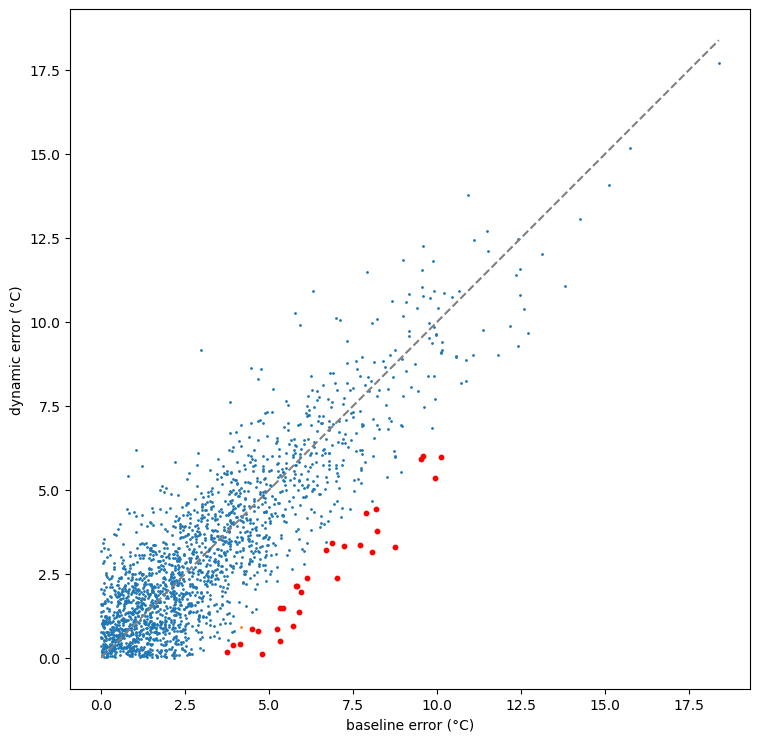

['D3YVZ9-AFv4' 'Q6L1A1-AFv4' 'P0AG51-AFv4' 'Q6KZ82-AFv4' 'P42923-AFv4'
 'P0AAR3-AFv4' 'Q72KZ7-AFv4' 'P36049-AFv4' 'Q08969-AFv4' 'P02309-AFv4'
 'P13663-AFv4' 'Q72GX4-AFv4' 'Q72JU4-AFv4' 'P0A9N0-AFv4' 'Q72K10-AFv4'
 'Q6KYX4-AFv4' 'Q6L177-AFv4' 'Q6L2J8-AFv4' 'Q9UN37-AFv4' 'P29018-AFv4'
 'Q8VEJ9-AFv4' 'P25605-AFv4' 'Q9SR37-AFv4' 'P0A7A5-AFv4' 'Q8L968-AFv4'
 'Q72HI3-AFv4' 'P0A6M2-AFv4' 'Q72HW6-AFv4' 'Q2V2P7-AFv4' 'P46367-AFv4']
['P02309-AFv4' 'P0AG51-AFv4' 'P29018-AFv4' 'P42923-AFv4' 'Q46864-AFv4'
 'Q6KYX4-AFv4' 'Q6KZ82-AFv4' 'Q9SR37-AFv4']

INTERSECTION
['P02309-AFv4' 'P0AG51-AFv4' 'P29018-AFv4' 'P42923-AFv4' 'Q6KYX4-AFv4'
 'Q6KZ82-AFv4' 'Q9SR37-AFv4']


In [84]:

base_err = np.abs(true_values[0]-predictions[0])
dyn_err = np.abs(true_values[-1]-predictions[-1])

improvements = base_err - dyn_err

idx_sorted = np.argsort(improvements)[::-1]

plt.hist(improvements, bins=50)
for v in np.percentile(improvements, [0, 100/3, 200/3, 100]):
    plt.axvline(
        v,
        linestyle='--',
        color='gray'
    )
plt.show()
plt.close()


fig, ax = plt.subplots(
    figsize=(7.48, 7.48),
    layout='constrained'
)

ax.plot(
    [min(base_err), max(base_err)],
    [min(base_err), max(base_err)],
    color='gray',
    linestyle='--',
)

loc = np.bitwise_and(
    dyn_err < 1,
    base_err > 4
)
ax.scatter(
    base_err[~loc],
    dyn_err[~loc],
    s=1,
)
ax.scatter(
    base_err[loc],
    dyn_err[loc],
    s=1,
)

ax.scatter(
    base_err[idx_sorted[:30]],
    dyn_err[idx_sorted[:30]],
    s=10,
    color='red',
)

ax.set_aspect('equal', 'box')

ax.set_xlabel('baseline error (°C)')
ax.set_ylabel('dynamic error (°C)')

plt.show()
plt.close()

print(accessions[idx_sorted[:30]])
print(accessions[loc])
print('\nINTERSECTION')
print(np.intersect1d(accessions[idx_sorted[:30]], accessions[loc]))
